In [504]:
import pandas as pd
import numpy as np
import datetime
import os
import datetime
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.cluster import KMeans
from datetime import timedelta, date
%matplotlib inline

### Method to get all channel file paths from the house directory

In [7]:
def get_channel_files(house_path):
    """
    Get channel files from the house directory. 
    
    Input:
    
    house_path = Path to house folder/directory
    
    Output:
    
    filepath_array = Array of file paths 
    
    """
    if(house_path[-1] != '/'):
        house_path = house_path + '/'
    filepath_array = []
    for x in os.listdir(house_path):
        if 'channel_' in x and x != "channel_1.dat":
            filepath_array.append(house_path + x)
    return filepath_array

### Method to read a channel file and add it to a dataframe

In [8]:
def read_channel_file(filepath):
    """
    This method reads channel file (.dat) using file path and returns a dataframe.
    
    Input:
    
    filepath = Path of the input channel (.dat) file
    
    Output:
    
    channel_df = Channel dataframe
    
    """
    channel_df = pd.read_csv(filepath, sep='\\s+', names=['Timestamp','Reading'], parse_dates=['Timestamp'], header=0)
    return channel_df

### Method to resample the channel usage in given time intervals

In [440]:
def resampling(input_df, time):
    """
    This method takes channel usage dataframe and time interval as input 
    and resamples the data by the input time. 
    
    Input:
    
    input_df = Channel usage dataframe
    time = time interval for resampling
    
    Output:
    
    final_data = Resampled dataframe
    
    """
    dataframe = input_df.set_index('Timestamp')
    dataframe.index = pd.to_datetime(dataframe.index,unit = "s")
    resample = dataframe.resample(time)
    resampled_data = resample.mean()
    final_data = resampled_data.reset_index()
    return final_data

### Class that handles figuring out channel's on/off states

In [10]:
class to_serialised_on_off():
    def __init__(self, data):
        # declaring min, max and avg values to be used later on
        self.data = data
        self.min_ = 0
        self.avg_ = 0
        self.max_ = 0
        self.find_min_max(flag = 1)

    def append_to_df(self, val):
        self.data.append(val)
        self.find_min_max()

    def find_min_max(self, flag = 0):
        """
        Method to find min and max value in the channel usage dataframe
        """
        if(flag == 0):
            val = self.data.loc[-1][-1]
            if( val > self.max_ ):
                self.max_ = val
            elif( val < self.min_ ):
                self.min_ = val
            self.avg_ += val/self.data.shape[0]
        elif(flag):
            self.max_ = max(self.data['Reading'])
            self.min_ = min(self.data['Reading'])
            self.avg_ = np.mean(self.data['Reading'].values)
        
        self.calc_thresh()

    def calc_thresh(self):
        """
        This method calculates the threshold value for deciding on/off state
        """
        self.thresh = (self.max_ - self.min_)/self.avg_
        print("Threshold Value : " + str(self.thresh))

    def on_off(self):
        of = []
        for i in range(self.data.shape[0]):
            if(self.data.loc[i][1] > self.thresh):
                of.append(str(self.data.loc[i][0]))
            else:
                of.append(0)
        return of

### Method to resample and generate channel's on/off status data

In [11]:
def generate_channel_on_off_data(filepath_list, resampling_time, output_files_location):
    """
    This method iterates over each channel in the house,
    resamples the input channel usage data, 
    categorizes each instance of resampled data into On/Off states,
    creates an array from it and saves it into a .npy file

    Input:

    filepath_list = List of paths of the channel (.dat) files from any house.
    resampling_time = String denoting the time interval for resampling (30min).
    output_files_location = Location of output .npy files.

    Returns:

    None

    """
    for file in filepath_list:
        df = read_channel_file(file)
        resampled_data = resampling(df, resampling_time)
        object_1 = to_serialised_on_off(resampled_data)
        on_off_array = object_1.on_off()
        filename = file.split('/')[-1].split('.')[0]+'.npy'
        if('button' in filename):
            continue
        np.save(output_files_location+filename, on_off_array)

### Method to get labels from the labels.dat file of UK-Dale dataset

In [12]:
def get_labels(filepath):
    """
    This method takes label file path as input and returns a dataframe with channel and appliance mappings
    
    Input:
    
    Label data file path.
    
    Output:
    
    Channel-Appliance name dataframe.
    
    """
    
    labels_df = pd.read_csv(labels_file_path, sep='\\s+', names=['Channel_id','Appliance'])
    labels_df["Channel_id"] = ["channel_"+str(i) for i in range(1,labels_df.shape[0]+1)]
    labels_dict = dict()
    for row in labels_df.iterrows():
        labels_dict[row[1]["Channel_id"]] = row[1]["Appliance"]
    return labels_df, labels_dict

### Declare file paths and resampling time

In [27]:
path_to_house = "../../../../Dataset/ukdale/house_3"
output_file_path = "./Channel_On_Off_data/House_3/"
resampling_time_in_min = "30min"

### Get the list of channel files for a house

In [36]:
filepath_list = get_channel_files(path_to_house)

### Resample data and then save channel On Off data into .npy files

In [37]:
generate_channel_on_off_data(filepath_list, resampling_time_in_min, output_file_path)

In [404]:
resampled_data.Reading

0       3.000000
1       3.156997
2       3.157534
3       3.054795
4       3.051370
          ...   
6828    3.554795
6829    3.460481
6830    3.398625
6831    3.380137
6832    3.516779
Name: Reading, Length: 6833, dtype: float64

In [2]:
channel_10 = np.load("./Channel_On_Off_data/House_2/channel_10.npy")

In [493]:
channel_10[:100]

array(['2013-04-16 21:00:00', '2013-04-16 21:30:00',
       '2013-04-16 22:00:00', '2013-04-16 22:30:00',
       '2013-04-16 23:00:00', '2013-04-16 23:30:00',
       '2013-04-17 00:00:00', '2013-04-17 00:30:00',
       '2013-04-17 01:00:00', '2013-04-17 01:30:00',
       '2013-04-17 02:00:00', '2013-04-17 02:30:00',
       '2013-04-17 03:00:00', '2013-04-17 03:30:00',
       '2013-04-17 04:00:00', '2013-04-17 04:30:00',
       '2013-04-17 05:00:00', '2013-04-17 05:30:00',
       '2013-04-17 06:00:00', '2013-04-17 06:30:00',
       '2013-04-17 07:00:00', '2013-04-17 07:30:00',
       '2013-04-17 08:00:00', '2013-04-17 08:30:00',
       '2013-04-17 09:00:00', '2013-04-17 09:30:00',
       '2013-04-17 10:00:00', '2013-04-17 10:30:00',
       '2013-04-17 11:00:00', '2013-04-17 11:30:00',
       '2013-04-17 12:00:00', '2013-04-17 12:30:00',
       '2013-04-17 13:00:00', '2013-04-17 13:30:00',
       '2013-04-17 14:00:00', '2013-04-17 14:30:00',
       '2013-04-17 15:00:00', '2013-04-17 15:3

In [15]:
resampling_time_in_min = "30min"
df = read_channel_file("../../../../Dataset/ukdale/house_2/channel_10.dat")
resampled_data = resampling(df, resampling_time_in_min)
object_1 = to_serialised_on_off(resampled_data)
on_off_array = object_1.on_off()

Threshold Value : 133.62352495836492


In [ ]:
self.min_ = 0
self.avg_ = 0
self.max_ = 0

In [16]:
object_1.min_

0

In [17]:
object_1.max_

112092

In [18]:
object_1.avg_

838.8642646190195

In [19]:
len(on_off_array)

8465

In [20]:
112091/839

133.60071513706794

In [21]:
resampled_data

,Timestamp,Reading
0,2013-04-16 21:00:00,959
1,2013-04-16 21:30:00,292
2,2013-04-16 22:00:00,297
3,2013-04-16 22:30:00,291
4,2013-04-16 23:00:00,298
...,...,...
8460,2013-10-10 03:00:00,296
8461,2013-10-10 03:30:00,291
8462,2013-10-10 04:00:00,291
8463,2013-10-10 04:30:00,292


In [22]:
dataframe = df.set_index('Timestamp')
dataframe.index = pd.to_datetime(dataframe.index,unit = "s")
resample = dataframe.resample("30min")
resampled_data = resample.sum()
final_data = resampled_data.reset_index()

In [23]:
dataframe

,Reading
Timestamp,
2013-04-16 21:18:15,10
2013-04-16 21:18:21,10
2013-04-16 21:18:27,10
2013-04-16 21:18:34,10
2013-04-16 21:18:40,10
...,...
2013-10-10 05:14:49,1
2013-10-10 05:14:56,1
2013-10-10 05:15:02,1


In [55]:
print(dataframe.index[290])
print(dataframe['Reading'][290:600].sum())

2013-04-16 21:48:06
314


In [102]:
resampled_data[resampled_data['Reading'] < 133.60071513706794]

,Reading
Timestamp,
2013-04-18 12:30:00,59
2013-04-18 13:00:00,72
2013-04-18 13:30:00,73
2013-04-18 14:30:00,62
2013-04-18 15:00:00,21
...,...
2013-09-11 11:00:00,0
2013-09-11 11:30:00,0
2013-09-11 12:00:00,0


In [59]:
resampled_data['Reading'].sum()

7100986

In [61]:
resampled_data['Reading'].mean()

838.8642646190195

In [93]:
# resampled_data.index[:10]

In [81]:
import matplotlib.pyplot as plt

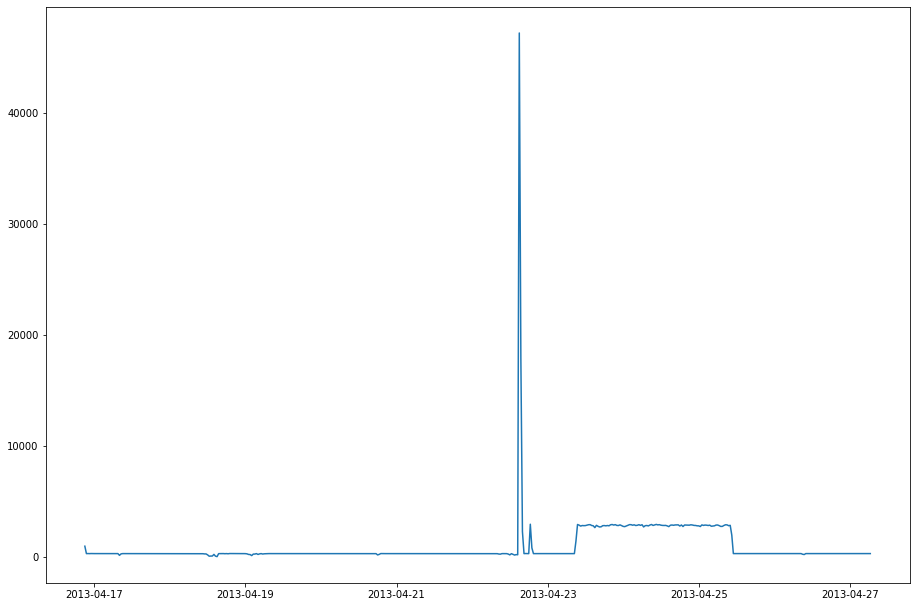

In [101]:
fig = plt.figure(figsize = (15,10))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
x = resampled_data.index[:500]
y = resampled_data['Reading'][:500]
axes.plot(x,y)
plt.show()

In [104]:
resampled_data[resampled_data['Reading'] == 148]

,Reading
Timestamp,
2013-10-10 05:00:00,148


In [105]:
(148-0)/(object_1.max_ - object_1.min_)

0.0013203440031402775

In [106]:
(56-0)/(object_1.max_ - object_1.min_)

0.0004995896228098348

In [147]:
resampled_data['quantile_reading_1'] = pd.qcut(resampled_data['Reading'], q=4)

In [148]:
resampled_data.head()

,Reading,quantile_reading_1
Timestamp,,
2013-04-16 21:00:00,959,"(295.0, 112092.0]"
2013-04-16 21:30:00,292,"(291.0, 293.0]"
2013-04-16 22:00:00,297,"(295.0, 112092.0]"
2013-04-16 22:30:00,291,"(-0.001, 291.0]"
2013-04-16 23:00:00,298,"(295.0, 112092.0]"


In [149]:
resampled_data['quantile_reading_1'].value_counts()

(-0.001, 291.0]      2700
(291.0, 293.0]       2438
(295.0, 112092.0]    1692
(293.0, 295.0]       1635
Name: quantile_reading_1, dtype: int64

In [146]:
resampled_data['quantile_reading_1'].value_counts()

(-0.001, 292.0]      4069
(294.0, 112092.0]    2444
(292.0, 294.0]       1952
Name: quantile_reading_1, dtype: int64

In [143]:
resampled_data['quantile_reading_1'].value_counts()

(-0.001, 293.0]      5138
(293.0, 112092.0]    3327
Name: quantile_reading_1, dtype: int64

In [312]:
resampling_time_in_min = "30min"
df = read_channel_file("../../../../Dataset/ukdale/house_2/channel_14.dat")
resampled_data = resampling(df, resampling_time_in_min)

In [313]:
# resampled_data['Reading'].describe()

In [181]:
resampled_data['quantile_reading_1'] = pd.qcut(resampled_data['Reading'], q=2)

In [182]:
resampled_data['quantile_reading_1'].value_counts()

(-0.001, 12226.0]     3417
(12226.0, 27381.0]    3416
Name: quantile_reading_1, dtype: int64

In [183]:
resampled_data['quantile_reading_2'] = pd.cut(resampled_data['Reading'], bins=2)

In [184]:
resampled_data['quantile_reading_2'].value_counts()

(-27.381, 13690.5]    4297
(13690.5, 27381.0]    2536
Name: quantile_reading_2, dtype: int64

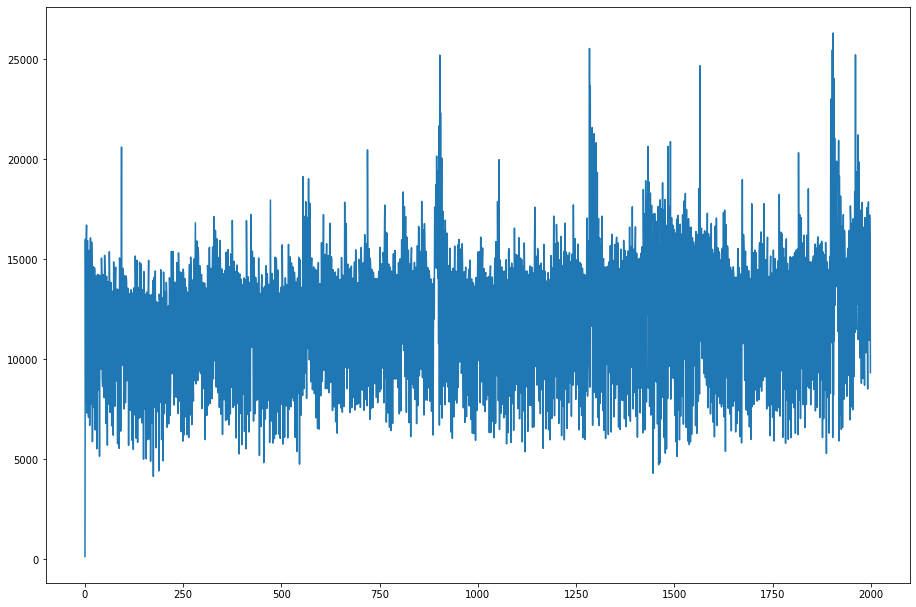

In [185]:
fig = plt.figure(figsize = (15,10))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
x = resampled_data.index[:2000]
y = resampled_data['Reading'][:2000]
axes.plot(x,y)
plt.show()

In [186]:
from math import sqrt

def stat(lst):
    """Calculate mean and std deviation from the input list."""
    n = float(len(lst))
    mean = sum(lst) / n
    stdev = sqrt((sum(x*x for x in lst) / n) - (mean * mean)) 
    return mean, stdev

def parse(lst, n):
    cluster = []
    for i in lst:
        if len(cluster) <= 1:    # the first two values are going directly in
            cluster.append(i)
            continue

        mean,stdev = stat(cluster)
        if abs(mean - i) > n * stdev:    # check the "distance"
            yield cluster
            cluster[:] = []    # reset cluster to the empty list

        cluster.append(i)
    yield cluster 

In [377]:
# for cluster in parse(sorted(resampled_data['Reading']), 7):
#     print(cluster)

In [204]:
import numpy as np
from scipy.cluster.vq import kmeans, vq


In [213]:
# y = np.array(resampled_data['Reading'])
# states, _ = kmeans(y, 2)  # three clusters
# cluster_indices, _ = vq(y, states)

In [218]:
# k = 2
# a = np.array(resampled_data['Reading'])
# a.sort()
# b=[] # A *heap* would be faster
# for i in range(1, len(a)):
#   b.append( (a[i]-a[i-1], i) )
# b.sort()
# # b now is [... (20, 6), (20, 9), (57, 3), (120, 7)]
# # and the last ones are the best split points.
# b = map(lambda p: p[1], b[-k:])
# b.sort()
# # b now is: [3, 7]
# b.insert(0, 0)
# b.append(len(a) + 1)
# for i in range(1, len(b)):
#   print(a[b[i-1]:b[i]])

In [250]:

import numpy as np

In [314]:
x = np.array(resampled_data['Reading'])

km = KMeans(n_clusters=2)
res = km.fit(x.reshape(-1,1))

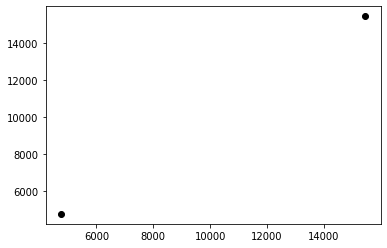

In [240]:
plt.scatter(km.cluster_centers_[:,0] ,km.cluster_centers_[:], color='black')

In [315]:
len(cluster_1)

2644

In [316]:
len(cluster_2)

4189

In [293]:
def get_resampled_df(df):
    df = read_channel_file("../../../../Dataset/ukdale/house_2/channel_"+str(channel_id)+".dat")
    resampled_data = resampling(df, resampling_time_in_min)
    return resampled_data

In [358]:
def apply_kmeans(column):
    x = np.array(column)
    km = KMeans(n_clusters=2)
    res = km.fit(x.reshape(-1,1))
    return x, km

In [499]:
def get_clusters(x, km, timeindex):
    times = []
    cluster_1 = []
    cluster_2 = []
    for i in range(len(km.labels_)):
        if(km.labels_[i] == 0):
            cluster_1.append(x[i])
            times.append('0')
        else:
            cluster_2.append(x[i])
            times.append(str(timeindex[i]))
    return cluster_1, cluster_2, times

In [466]:
def get_counts(channel_id):
    channel_data = np.load()
    count = 0
    for i in channel_data:
        if i == '0':
            count+=1
    print(len(channel_data) - count)
    print(count)        

In [519]:
def get_channel_on_off_data(filepath_list, output_files_location):
    for file in filepath_list:
        if('button' in file):
            continue
        df = read_channel_file(file)
        resampled_data = resampling(df, resampling_time_in_min)
        resampled_data = resampled_data.fillna(0)
        x, km = apply_kmeans(resampled_data['Reading'])
        cluster_1, cluster_2, times = get_clusters(x, km, resampled_data.Timestamp)
        filename = file.split('/')[-1].split('.')[0]+'.npy'
        np.save(output_files_location+filename, times)

In [520]:
path_to_house = "../../../../Dataset/ukdale/house_2"
output_file_path = "./Kmeans/Channel_On_Off_data/House_2/"
resampling_time_in_min = "30min"

In [521]:
filepath_list = get_channel_files(path_to_house)

In [522]:
# filepath_list

In [523]:
get_channel_on_off_data(filepath_list, output_file_path)

In [526]:
channel_12 = np.load("./Kmeans/Channel_On_Off_data/House_2/channel_12.npy")

In [528]:
channel_12[-100:]

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '2013-10-08 08:30:00', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0'], dtype='<U19')

In [529]:
channel = 12
resampled_data = get_resampled_df(channel)
resampled_data = resampled_data.fillna(0)
x, km = apply_kmeans(resampled_data['Reading'])
cluster_1, cluster_2, times = get_clusters(x, km, resampled_data.Timestamp)
print(len(cluster_2))
print(len(cluster_1))
print()
get_counts(channel)

70
6763

5763
1070


In [463]:
resampled_data['Reading'].max()

77.26460481099656

In [531]:
for item in times:
    if item != '0':
        print(item)
    

2013-05-26 09:00:00
2013-05-26 10:30:00
2013-05-26 11:30:00
2013-05-26 12:00:00
2013-05-26 12:30:00
2013-06-02 10:00:00
2013-06-02 10:30:00
2013-06-02 11:00:00
2013-06-02 11:30:00
2013-06-08 10:30:00
2013-06-08 11:00:00
2013-06-09 12:00:00
2013-06-09 12:30:00
2013-06-12 09:00:00
2013-06-15 07:30:00
2013-06-15 08:00:00
2013-06-15 12:00:00
2013-06-16 11:00:00
2013-06-22 09:30:00
2013-06-22 10:00:00
2013-06-23 08:00:00
2013-06-23 08:30:00
2013-06-23 09:30:00
2013-06-29 10:00:00
2013-06-29 11:00:00
2013-06-29 11:30:00
2013-06-30 11:30:00
2013-07-06 08:30:00
2013-07-06 09:30:00
2013-07-06 11:30:00
2013-07-06 14:00:00
2013-07-13 10:00:00
2013-07-13 11:30:00
2013-07-13 12:30:00
2013-07-19 09:30:00
2013-07-19 10:00:00
2013-07-23 08:00:00
2013-07-24 12:00:00
2013-07-27 08:30:00
2013-07-27 12:00:00
2013-07-27 12:30:00
2013-07-28 12:30:00
2013-08-01 10:00:00
2013-08-01 11:30:00
2013-08-01 12:00:00
2013-08-03 08:00:00
2013-08-04 11:00:00
2013-08-23 07:30:00
2013-08-23 08:00:00
2013-08-23 08:30:00


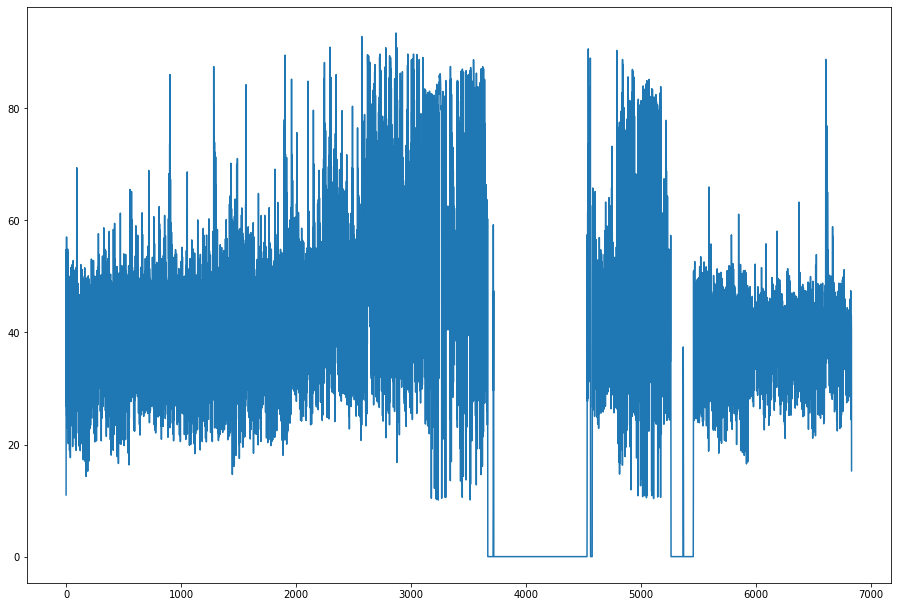

In [489]:
fig = plt.figure(figsize = (15,10))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
x = resampled_data.index[:7000]
y = resampled_data['Reading'][:7000]
axes.plot(x,y)
plt.show()

In [413]:
resampled_data

,Timestamp,Reading
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
6828,6828,0.0
6829,6829,0.0
6830,6830,0.0
6831,6831,0.0


In [351]:
km.labels_[:200]

array([1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 1], dtype=int32)

In [352]:
resampled_data.head()

,Timestamp,Reading
0,2013-05-20 21:00:00,143
1,2013-05-20 21:30:00,16002
2,2013-05-20 22:00:00,7847
3,2013-05-20 22:30:00,15604
4,2013-05-20 23:00:00,16714


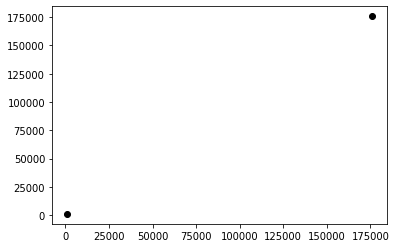

In [346]:
plt.scatter(km.cluster_centers_[:,0] ,km.cluster_centers_[:], color='black')

In [401]:
channel = 12
resampled_data = get_resampled_df(channel)
resampled_data = resampled_data.fillna(0)
x, km = apply_kmeans(resampled_data['Reading'])
cluster_1, cluster_2 = get_clusters(x, km)
print(len(cluster_2))
print(len(cluster_1))
print()
get_counts(channel)

70
6763

5763
1070


In [376]:
count = 0
on_count = 0
channel = 18
arr = get_resampled_df(channel)['Reading']
clusters = []
for cluster in parse(sorted(arr), 7):
    clusters.append(cluster)
    
for cluster in clusters:
    count+=1
    if(len(clusters) > 2):
        if(count <3):
            print(cluster)
            print()
        else:
            on_count += len(cluster)
    else:
        if(count > 1):
            print(cluster)
            print()
print(count)

print()
print(on_count)
print(len(arr) - on_count)

print()
get_counts(channel)

[9, 117, 153, 162, 298, 379, 505, 720, 866, 973, 1009, 1218, 1265, 1269, 1333, 1351, 1362, 1378, 1415, 1424, 1451, 1514, 1530, 1542, 1548, 1584, 1597, 1617, 1624, 1629, 1692, 1719, 1738, 1749, 1765, 1765, 1769, 1787, 1809, 1827, 1872, 1873, 1891, 1893, 1908, 1913, 1919, 1953, 1962, 1972, 1974, 2001, 2009, 2016, 2016, 2018, 2032, 2035, 2044, 2044, 2046, 2047, 2048, 2048, 2048, 2049, 2049, 2050, 2050, 2051, 2051, 2051, 2051, 2051, 2051, 2051, 2051, 2051, 2051, 2051, 2051, 2051, 2051, 2051, 2051, 2056, 2056, 2057, 2057, 2057, 2057, 2058, 2058, 2058, 2058, 2058, 2058, 2058, 2058, 2058, 2058, 2058, 2058, 2058, 2058, 2058, 2058, 2059, 2061, 2063, 2063, 2063, 2064, 2064, 2064, 2065, 2065, 2065, 2065, 2065, 2065, 2065, 2065, 2065, 2065, 2065, 2065, 2065, 2065, 2066, 2069, 2070, 2071, 2071, 2071, 2071, 2071, 2072, 2078, 2083, 2090, 2091, 2093, 2102, 2128, 2131, 2138, 2138, 2145, 2146, 2151, 2154, 2173, 2180, 2189, 2190, 2190, 2211, 2217, 2224, 2236, 2237, 2250, 2251, 2252, 2259, 2269, 2272, 227